# TODO:

- timezones
- cities (populated areas)
- oceans, seas, lakes, rivers
- parks and protected areas
- glaciated areas
- airports

In [1]:
import sqlite3
from shapely.wkb import dumps, loads
from shapely.geometry import Polygon, MultiPolygon, Point, box, shape, geo
from shapely.ops import cascaded_union
import geohash
import pandas as pd
import numpy as np
from shapely.ops import cascaded_union
from georaptor import compress
import geog

In [2]:
def neighbor(geo_hash, direction):
    """
    Find neighbor of a geohash string in certain direction.
    :param geo_hash: geohash string
    :type geo_hash: str
    :param direction: Direction is a two-element array, i.e. [1,0] means north, [1,1] means northeast
    :type direction: list
    :return: geohash string
    :rtype: str
    """
    decode_result = geohash.decode_exactly(geo_hash)
    neighbor_lat = decode_result[0] + direction[0] * decode_result[2] * 2
    neighbor_lon = decode_result[1] + direction[1] * decode_result[3] * 2
    return geohash.encode(neighbor_lat, neighbor_lon, len(geo_hash))

def geohash_shape(shp, precision, mode='intersect', threshold=None):
    """
    Find list of geohashes to cover the shape
    :param shp: shape to cover
    :type shp: BaseGeometry
    :param precision: geohash precision
    :type precision: int
    :param mode: 'intersect' - all geohashes intersect the shape
                               use 'threashold' option to specify a percentage of least coverage
                 'inside' - all geohashes inside the shape
                 'center' - all geohashes whose center is inside the shape
    :type mode: str
    :param threshold: percentage of least coverage
    :type threshold: float
    :return: list of geohashes
    :rtype: list
    """
    (min_lon, min_lat, max_lon, max_lat) = shp.bounds

    hash_south_west = geohash.encode(min_lat, min_lon, precision)
    hash_north_east = geohash.encode(max_lat, max_lon, precision)

    box_south_west = geohash.decode_exactly(hash_south_west)
    box_north_east = geohash.decode_exactly(hash_north_east)

    per_lat = box_south_west[2] * 2
    per_lon = box_south_west[3] * 2

    lat_step = int(round((box_north_east[0] - box_south_west[0]) / per_lat))
    lon_step = int(round((box_north_east[1] - box_south_west[1]) / per_lon))

    hash_list = []

    for lat in range(0, lat_step + 1):
        for lon in range(0, lon_step + 1):
            next_hash = neighbor(hash_south_west, [lat, lon])
            if mode == 'center':
                (lat_center, lon_center) = geohash.decode(next_hash)
                if shp.contains(Point(lon_center, lat_center)):
                    hash_list.append(next_hash)
            else:
                next_bbox = geohash.bbox(next_hash)
                next_bbox_geom = box(next_bbox['w'], next_bbox['s'], next_bbox['e'], next_bbox['n'])

                if mode == 'inside':
                    if shp.contains(next_bbox_geom):
                        hash_list.append(next_hash)
                elif mode == 'intersect':
                    if shp.intersects(next_bbox_geom):
                        if threshold is None:
                            hash_list.append(next_hash)
                        else:
                            intersected_area = shp.intersection(next_bbox_geom).area
                            if (intersected_area / next_bbox_geom.area) >= threshold:
                                hash_list.append(next_hash)

    return hash_list

In [3]:
conn = sqlite3.connect('ne_10m_admin_0_countries/natural_earth_vector.sqlite')

In [4]:
generated_db = sqlite3.connect('generated.sqlite')

In [61]:
geohash_characters = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'j', 'k', 'm', 'n', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

In [5]:
# list(conn.execute("SELECT geometry FROM ne_10m_land"))

land = cascaded_union([loads(row[0]) for row in list(conn.execute("SELECT geometry FROM ne_110m_land"))])
lakes = cascaded_union([loads(row[0]) for row in list(conn.execute("SELECT geometry FROM ne_110m_lakes"))])
ocean = cascaded_union([loads(row[0]) for row in list(conn.execute("SELECT geometry FROM ne_110m_ocean"))])
pure_land = land.difference(lakes)

# pure_land.wkt

In [6]:
geohash.encode(0, 0, 4)

's000'

In [7]:
geohash.decode('ebpb')

(0.087890625, -0.17578125)

In [8]:
geohash.expand(geohash.encode(0, 0, 4))

['ebpb', 's002', 'kpbp', '7zzz', 'kpbr', 's001', 'ebpc', 's003', 's000']

# Countries

In [5]:
countries = pd.DataFrame(list(conn.execute("SELECT adm0_a3, GEOMETRY, name, pop_est, economy, income_grp, continent, region_un, subregion FROM ne_10m_admin_0_countries")))
countries.columns = ['adm0_a3', 'GEOMETRY', 'name', 'pop_est', 'economy', 'income_grp', 'continent', 'region_un', 'subregion']
countries = countries.set_index('adm0_a3')

In [11]:
countries_110 = pd.DataFrame(list(conn.execute("SELECT adm0_a3, GEOMETRY FROM ne_110m_admin_0_countries")))
countries_110.columns = ['adm0_a3', 'GEOMETRY']
countries_110 = countries_110.set_index('adm0_a3')
countries['GEOMETRY_110m'] = countries_110.GEOMETRY

In [12]:
countries_50 = pd.DataFrame(list(conn.execute("SELECT adm0_a3, GEOMETRY FROM ne_50m_admin_0_countries")))
countries_50.columns = ['adm0_a3', 'GEOMETRY']
countries_50 = countries_50.set_index('adm0_a3')
countries['GEOMETRY_50m'] = countries_50.GEOMETRY

In [13]:
countries.head()

,GEOMETRY,name,pop_est,economy,income_grp,continent,region_un,subregion,GEOMETRY_110m,GEOMETRY_50m
adm0_a3,,,,,,,,,,
IDN,b'\x01\x06\x00\x00\x00\x08\x01\x00\x00\x01\x03...,Indonesia,260580739,4. Emerging region: MIKT,4. Lower middle income,Asia,Asia,South-Eastern Asia,b'\x01\x06\x00\x00\x00\r\x00\x00\x00\x01\x03\x...,b'\x01\x06\x00\x00\x00\x85\x00\x00\x00\x01\x03...
MYS,b'\x01\x06\x00\x00\x00\x11\x00\x00\x00\x01\x03...,Malaysia,31381992,6. Developing region,3. Upper middle income,Asia,Asia,South-Eastern Asia,b'\x01\x06\x00\x00\x00\x02\x00\x00\x00\x01\x03...,b'\x01\x06\x00\x00\x00\t\x00\x00\x00\x01\x03\x...
CHL,b'\x01\x06\x00\x00\x00\xa3\x00\x00\x00\x01\x03...,Chile,17789267,5. Emerging region: G20,3. Upper middle income,South America,Americas,South America,b'\x01\x06\x00\x00\x00\x02\x00\x00\x00\x01\x03...,b'\x01\x06\x00\x00\x00\x1f\x00\x00\x00\x01\x03...
BOL,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\xd3\x05...,Bolivia,11138234,5. Emerging region: G20,4. Lower middle income,South America,Americas,South America,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00<\x00\x0...,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\xa2\x01...
PER,b'\x01\x06\x00\x00\x00\x05\x00\x00\x00\x01\x03...,Peru,31036656,5. Emerging region: G20,3. Upper middle income,South America,Americas,South America,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00L\x00\x0...,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00M\x02\x0...


In [58]:
loads(countries.iloc[0]['GEOMETRY']).wkt

'MULTIPOLYGON (((117.7036079039552 4.163414542001791, 117.7036079040001 4.163414542000055, 117.7380714620001 4.157241908000032, 117.7835722470001 4.157241908000032, 117.8525573090001 4.157241908000032, 117.9070390276059 4.156683015004099, 117.9121199880001 4.144924221000053, 117.918223504 4.100043036000045, 117.934825066 4.059881903000075, 117.9013778000001 4.036688544000071, 117.887054884 4.031927802000041, 117.8725692070001 4.03156159100007, 117.83855228 4.040187893000052, 117.81910241 4.06867096600007, 117.7627059250001 4.100734768000052, 117.739431186 4.132310289000088, 117.7036079039552 4.163414542001791)), ((124.450531446 -9.180189710999912, 124.4658309250001 -9.17937590899993, 124.517832879 -9.177829684999949, 124.563243035 -9.170830987999921, 124.60434004 -9.156345309999949, 124.6679793630001 -9.113051039999959, 124.671153191 -9.107517184999949, 124.673187696 -9.09929778399993, 124.6836043630001 -9.074802341999941, 124.6879988940001 -9.069512627999927, 124.6915796230001 -9.0678

In [54]:
import time
# usa = loads(countries.loc[countries.name == 'United States of America'].iloc[0]['GEOMETRY'])

point = Point(105.139216, 10.870396)
times = []
for i in range(100):
    start_time = time.time()
    for _, country in countries.iterrows():
        point.within(loads(country['GEOMETRY']))
    elapsed_time = time.time() - start_time
    times.append(elapsed_time)
    
np.mean(times)

0.060994970798492434

In [32]:
len(countries)

255

In [14]:
country_polygons = {}
for sov, country in countries.iterrows():
    polygon = loads(country['GEOMETRY'])
    country_polygons[sov] = polygon

In [15]:
def country_for_geohash(gh):
    pos = geohash.decode(gh)
    point = Point(pos[1], pos[0])
    
    distances = [(country, country_polygons[country].distance(point)) for country in country_polygons]
    closest_country = min(distances, key=lambda x: x[1])[0]
    return closest_country

In [64]:
generated_db.execute('DROP TABLE countries;')

generated_db.execute('CREATE TABLE countries (adm0_a3 TEXT PRIMARY KEY NOT NULL, name TEXT NOT NULL, pop_est INTEGER, economy TEXT, income_grp TEXT, continent TEXT, region_un TEXT, subregion TEXT, geometry BLOB, geometry_50m BLOB, geometry_110m BLOB, latitude REAL, longitude REAL);')

In [16]:
def centroid_of(geom):
    if type(geom) is MultiPolygon:
        return max(geom, key=lambda x: x.area).centroid
    
    return geom.centroid

In [66]:
for sov_a3, country in countries.iterrows():
    center = centroid_of(loads(country['GEOMETRY']))
    generated_db.execute('INSERT INTO countries (adm0_a3, name, pop_est, economy, income_grp, continent, region_un, subregion, geometry, geometry_50m, geometry_110m, latitude, longitude) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)', [
        sov_a3, country['name'], country['pop_est'], country['economy'], country['income_grp'], country['continent'], country['region_un'], country['subregion'], country['GEOMETRY'], country['GEOMETRY_50m'], country['GEOMETRY_110m'], center.y, center.x
    ])
generated_db.commit()

In [67]:
generated_db.execute('DROP TABLE geohash_countries;')
generated_db.execute('CREATE TABLE geohash_countries (geohash TEXT PRIMARY KEY NOT NULL, adm0_a3 TEXT NOT NULL);')

In [ ]:
max_depth = 5

for country, row in countries.iloc[166:].iterrows():
    print(country, 'starting')
    
    geometry = loads(row.GEOMETRY)
    center_geohashes = set(geohash_shape(geometry, precision=max_depth, mode='center'))
    intersecting_geohashes = set(geohash_shape(geometry, precision=max_depth, mode='intersect'))
    intersecting_geohashes = intersecting_geohashes - center_geohashes
    
    if type(center_geohashes) == set and len(center_geohashes) > 0:
        for gh in intersecting_geohashes:
            if country_for_geohash(gh) == country:
                center_geohashes.add(gh)
        center_geohashes = compress(center_geohashes, minlevel=2, maxlevel=max_depth)

        for gh in center_geohashes:
            generated_db.execute('INSERT INTO geohash_countries (geohash, adm0_a3) VALUES (?, ?)', [ gh, country ])
        generated_db.commit()

        print(country, 'done', len(center_geohashes))

VAT starting
CYN starting
CYN done 221
CNM starting
CNM done 16
KAS starting
KAS done 75
KAB starting
KAB done 207
WSB starting
WSB done 12
ATA starting
ATA done 129
AUS starting
AUS done 16967
GRL starting


In [17]:
max_depth = 5

def find_child_geohash_mappings(previous_hash='', previous_country=''):
    for char in geohash_characters:
        new_hash = previous_hash + char
        new_country = country_for_geohash(new_hash)
        
        if new_country != previous_country:
            generated_db.execute('INSERT INTO geohash_countries (geohash, adm0_a3) VALUES (?, ?)', [ new_hash, new_country ])
            generated_db.commit()
            
        if len(new_hash) < max_depth:
            find_child_geohash_mappings(new_hash, new_country)

find_child_geohash_mappings()

KeyboardInterrupt: 

In [75]:
for char1 in geohash_characters:
    for char2 in geohash_characters:
        gh = char1 + char2
        table = 'geohash_countries_' + gh
        generated_db.execute('DROP TABLE IF EXISTS ' + table + ';')
        generated_db.execute('CREATE TABLE ' + table + ' (geohash TEXT PRIMARY KEY NOT NULL, adm0_a3 TEXT NOT NULL)')
        generated_db.execute("INSERT INTO " + table + " SELECT * FROM geohash_countries WHERE geohash LIKE '" + gh + "%';")
        generated_db.commit()

# States

In [17]:
columns = [
    'GEOMETRY',
    'adm1_code',
    'name',
    'name_en',
    'type',
    'type_en',
    'adm0_a3'
]

states_provinces = pd.DataFrame(list(conn.execute("SELECT " + ','.join(columns) + " FROM ne_10m_admin_1_states_provinces")))
states_provinces.columns = columns
states_provinces = states_provinces.set_index('adm1_code')
states_provinces = states_provinces.loc[~states_provinces.name.isnull()]
states_provinces.head()

,GEOMETRY,name,name_en,type,type_en,adm0_a3
adm1_code,,,,,,
ARG-1309,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00[\x01\x0...,Entre Ríos,Entre Ríos Province,Provincia,Province,ARG
URY-8,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x01...,Paysandú,Paysandú Department,Departamento,Department,URY
PAK-1114,b'\x01\x06\x00\x00\x00\x02\x00\x00\x00\x01\x03...,Sind,Sindh,Province,Province,PAK
IND-3264,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00E\x07\x0...,Gujarat,Gujarat,None,None,IND
IDN-1185,b'\x01\x06\x00\x00\x00\t\x00\x00\x00\x01\x03\x...,Kalimantan Timur,East Kalimantan,Propinsi,Province,IDN


In [18]:
states_provinces_110 = pd.DataFrame(list(conn.execute("SELECT adm1_code, GEOMETRY FROM ne_110m_admin_1_states_provinces")))
states_provinces_110.columns = ['adm1_code', 'GEOMETRY']
states_provinces_110 = states_provinces_110.set_index('adm1_code')
states_provinces['GEOMETRY_110m'] = states_provinces_110.GEOMETRY

In [19]:
states_provinces_50 = pd.DataFrame(list(conn.execute("SELECT adm1_code, GEOMETRY FROM ne_50m_admin_1_states_provinces")))
states_provinces_50.columns = ['adm1_code', 'GEOMETRY']
states_provinces_50 = states_provinces_50.set_index('adm1_code')
states_provinces['GEOMETRY_50m'] = states_provinces_50.GEOMETRY

In [43]:
generated_db.execute('DROP TABLE states_provinces;')

generated_db.execute('CREATE TABLE states_provinces (adm1_code TEXT PRIMARY KEY NOT NULL, adm0_a3 TEXT NOT NULL, name TEXT NOT NULL, name_en TEXT, type TEXT, type_en TEXT, geometry BLOB, geometry_50m BLOB, geometry_110m BLOB, latitude REAL, longitude REAL);')

In [44]:
for adm1_code, state in states_provinces.iterrows():
    center = centroid_of(loads(state['GEOMETRY']))
    generated_db.execute('INSERT INTO states_provinces (adm1_code, adm0_a3, name, name_en, type, type_en, geometry, geometry_50m, geometry_110m, latitude, longitude) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)', [
        adm1_code, state['adm0_a3'], state['name'], state['name_en'], state['type'], state['type_en'], state['GEOMETRY'], state['GEOMETRY_50m'], state['GEOMETRY_110m'], center.y, center.x
    ])
generated_db.commit()

In [24]:
generated_db.execute('DROP TABLE geohash_states_provinces;')
generated_db.execute('CREATE TABLE geohash_states_provinces (geohash TEXT PRIMARY KEY NOT NULL, adm1_code TEXT NOT NULL);')

In [20]:
states_polygons = {}
for sov, country in states_provinces.iterrows():
    polygon = loads(country['GEOMETRY'])
    states_polygons[sov] = polygon

In [29]:
len('dfsdafa'[:-1])

6

In [20]:
def country_for_geohash_from_db(gh):
    results = list(generated_db.execute("SELECT adm0_a3 FROM geohash_countries WHERE geohash = ?", [gh]))
    if len(results) > 0:
        return results[0][0]
    else:
        return country_for_geohash_from_db(gh[:-1])

In [35]:
def state_for_geohash(gh, country):
    pos = geohash.decode(gh)
    point = Point(pos[1], pos[0])
    
    states = states_provinces.loc[states_provinces.adm0_a3 == country].index
    if len(states) == 0:
        return ''
    
    distances = [(state, states_polygons[state].distance(point)) for state in states]
    closest_state = min(distances, key=lambda x: x[1])[0]
    return closest_state

In [23]:
states_provinces.head()

,GEOMETRY,name,name_en,type,type_en,adm0_a3,GEOMETRY_110m,GEOMETRY_50m
adm1_code,,,,,,,,
ARG-1309,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00[\x01\x0...,Entre Ríos,Entre Ríos Province,Provincia,Province,ARG,NaN,NaN
URY-8,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x01...,Paysandú,Paysandú Department,Departamento,Department,URY,NaN,NaN
PAK-1114,b'\x01\x06\x00\x00\x00\x02\x00\x00\x00\x01\x03...,Sind,Sindh,Province,Province,PAK,NaN,NaN
IND-3264,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00E\x07\x0...,Gujarat,Gujarat,None,None,IND,NaN,NaN
IDN-1185,b'\x01\x06\x00\x00\x00\t\x00\x00\x00\x01\x03\x...,Kalimantan Timur,East Kalimantan,Propinsi,Province,IDN,NaN,NaN


In [36]:
max_depth = 5

for state, row in states_provinces.iterrows():
    print(state, 'starting')
    
    geometry = loads(row.GEOMETRY)
    center_geohashes = set(geohash_shape(geometry, precision=max_depth, mode='center'))
    intersecting_geohashes = set(geohash_shape(geometry, precision=max_depth, mode='intersect'))
    intersecting_geohashes = intersecting_geohashes - center_geohashes
    
    if type(center_geohashes) == set and len(center_geohashes) > 0:
        for gh in intersecting_geohashes:
            country = country_for_geohash(gh)
            if state_for_geohash(gh, country) == state:
                center_geohashes.add(gh)
        center_geohashes = compress(center_geohashes, minlevel=2, maxlevel=max_depth)

        for gh in center_geohashes:
            generated_db.execute('INSERT INTO geohash_states_provinces (geohash, adm1_code) VALUES (?, ?)', [ gh, state ])
        generated_db.commit()

        print(state, 'done', len(center_geohashes))

ARG-1309 starting
ARG-1309 done 1042
URY-8 starting
URY-8 done 287
PAK-1114 starting
PAK-1114 done 1289
IND-3264 starting
IND-3264 done 2062
IDN-1185 starting
IDN-1185 done 1848
MYS-1186 starting
MYS-1186 done 1066
CHL-2694 starting
CHL-2694 done 361
BOL-1936 starting
BOL-1936 done 1428
BOL-1937 starting
BOL-1937 done 703
CHL-2693 starting
CHL-2693 done 590
BOL-1939 starting
BOL-1939 done 1322
CHL-2695 starting
CHL-2695 done 1177
PER-575 starting
PER-575 done 316
ARG-1303 starting
ARG-1303 done 2044
ARG-1301 starting
ARG-1301 done 810
ESB-5132 starting
ESB-5132 done 9
IND-2431 starting
IND-2431 done 1309
CHN-1756 starting
CHN-1756 done 5168
CHN-1662 starting
CHN-1662 done 4824
ISR-3053 starting
ISR-3053 done 440
GAZ+00? starting
GAZ+00? done 22
ISR-3056 starting
ISR-3056 done 144
WEB+00? starting
WEB+00? done 197
ISR-3054 starting
ISR-3054 done 50
ISR-3055 starting
ISR-3055 done 62
ISR-3058 starting
ISR-3058 done 24
LBN-3059 starting
LBN-3059 done 54
LBN-3060 starting
LBN-3060 done 60


In [20]:
max_depth = 4

def find_child_state_geohash_mappings(previous_hash='', previous_state=''):
    for char in geohash_characters:
        new_hash = previous_hash + char
        new_country = country_for_geohash_from_db(new_hash)
        new_state = state_for_geohash(new_hash, new_country)
        
        if new_state != previous_state:
            generated_db.execute('INSERT INTO geohash_states_provinces (geohash, adm1_code) VALUES (?, ?)', [ new_hash, new_state ])
            generated_db.commit()
            
        if len(new_hash) < max_depth:
            find_child_state_geohash_mappings(new_hash, new_state)

find_child_state_geohash_mappings()

In [74]:
for char1 in geohash_characters:
    for char2 in geohash_characters:
        gh = char1 + char2
        table = 'geohash_states_provinces_' + gh
        generated_db.execute('DROP TABLE IF EXISTS ' + table + ';')
        generated_db.execute('CREATE TABLE ' + table + ' (geohash TEXT PRIMARY KEY NOT NULL, adm1_code TEXT NOT NULL);')
        generated_db.execute("INSERT INTO " + table + " SELECT * FROM geohash_states_provinces WHERE geohash LIKE '" + gh + "%';")
        generated_db.commit()

# Cities

In [60]:
columns = [
    'ogc_fid',
    'adm0_a3',
    'name',
    'name_en',
    'megacity',
    'worldcity',
    'latitude',
    'longitude',
    'pop_max',
    'pop_min',
    'min_areakm',
    'max_areakm'
]

cities = pd.DataFrame(list(conn.execute("SELECT " + ','.join(columns) + " FROM ne_10m_populated_places")))
cities.columns = columns
cities = cities.set_index('ogc_fid')
cities.head()

,adm0_a3,name,name_en,megacity,worldcity,latitude,longitude,pop_max,pop_min,min_areakm,max_areakm
ogc_fid,,,,,,,,,,,
1,URY,Colonia del Sacramento,Colonia del Sacramento,0,0.0,-34.479999,-57.840002,21714,21714,0.0,0.0
2,URY,Trinidad,Trinidad,0,0.0,-33.543999,-56.900997,21093,21093,0.0,0.0
3,URY,Fray Bentos,Fray Bentos,0,0.0,-33.138999,-58.303997,23279,23279,0.0,0.0
4,URY,Canelones,Canelones,0,0.0,-34.538004,-56.284001,19698,19698,0.0,0.0
5,URY,Florida,Florida,0,0.0,-34.099002,-56.214998,32234,32234,0.0,0.0


In [61]:
cities['geohash'] = [geohash.encode(city.latitude, city.longitude, 4) for _, city in cities.iterrows()]

In [62]:
generated_db.execute('DROP TABLE cities;')
generated_db.execute('DROP TABLE geohash_cities;')

In [63]:
generated_db.execute('CREATE TABLE cities (ogc_fid INTEGER PRIMARY KEY NOT NULL, adm0_a3 TEXT NOT NULL, name TEXT NOT NULL, pop_min INTEGER, pop_max INTEGER, name_en TEXT, megacity INTEGER, worldcity INTEGER, min_areakm REAL, max_areakm REAL, latitude REAL, longitude REAL);')

In [64]:
generated_db.execute('CREATE TABLE geohash_cities (geohash TEXT NOT NULL, ogc_fid INTEGER NOT NULL);')
generated_db.execute('CREATE INDEX geohash_cities_geohash_idx ON geohash_cities (geohash);')

In [65]:
def buffer_point_in_meters(longitude, latitude, distance_meters):
    n_points = 24
    angles = np.linspace(0, 360, n_points)
    return Polygon(geog.propagate((longitude, latitude), angles, distance_meters))

In [66]:
geohash_length = 5

for ogc_fid, city in cities.iterrows():
    generated_db.execute('INSERT INTO cities (ogc_fid, adm0_a3, name, name_en, megacity, worldcity, latitude, longitude, pop_max, pop_min, min_areakm, max_areakm) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)', [
        ogc_fid, city['adm0_a3'], city['name'], city['name_en'], city['megacity'], city['worldcity'], city['latitude'], city['longitude'], city['pop_max'], city['pop_min'], city['min_areakm'], city['max_areakm']
    ])
    
    # < 100000: 1km
    # < 1000000: 3km
    # < 10000000: 5km
    # > : 10km
    radius = 1000
    if city['pop_max'] > 10000000:
        radius = 10000
    elif city['pop_max'] > 1000000:
        radius = 5000
    elif city['pop_max'] > 100000:
        radius = 3000
    
    geometry = buffer_point_in_meters(city.longitude, city.latitude, radius)
    geohashes = geohash_shape(geometry, precision=geohash_length, mode='intersect')
    
    for gh in geohashes:
        generated_db.execute('INSERT INTO geohash_cities (geohash, ogc_fid) VALUES (?, ?)', [ gh, ogc_fid ])
        
generated_db.commit()

# Timezones

In [17]:
timezones_df = pd.DataFrame(list(conn.execute("SELECT ogc_fid, time_zone AS name, name AS value, places, geometry FROM ne_10m_time_zones")))
timezones_df.columns = ['ogc_fid', 'name', 'value', 'places', 'geometry']
timezones_df = timezones_df.set_index('ogc_fid')
timezones_df.head()

,name,value,places,geometry
ogc_fid,,,,
1,UTC-10:00,-10,Arctic Ocean,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\xd2\x00...
2,UTC-10:00,-10,United States (Aleutian Islands),b'\x01\x03\x00\x00\x00\x01\x00\x00\x00T\x00\x0...
3,UTC-11:00,-11,Arctic Ocean,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\xb7\x00...
4,UTC-11:00,-11,"American Samoa, Niue",b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x8e\x00...
5,UTC-11:00,-11,"American Samoa, Niue",b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\xb5\x00...


In [5]:
timezone_polygons = {}
for ogc_fid, timezone in timezones_df.iterrows():
    polygon = loads(timezone['geometry'])
    timezone_polygons[ogc_fid] = polygon

In [44]:
generated_db.execute('CREATE TABLE geohash_timezones (geohash TEXT PRIMARY KEY NOT NULL, ogc_fid INTEGER NOT NULL);')

In [46]:
def timezone_for_geohash(gh):
    pos = geohash.decode(gh)
    point = Point(pos[1], pos[0])
    
    distances = [(timezone, timezone_polygons[timezone].distance(point)) for timezone in timezone_polygons]
    closest_timezone = min(distances, key=lambda x: x[1])[0]
    return closest_timezone

In [51]:
max_depth = 4

def find_child_timezone_geohash_mappings(previous_hash='', previous_timezone=''):
    for char in geohash_characters:
        new_hash = previous_hash + char
        new_timezone = timezone_for_geohash(new_hash)
        
        if new_timezone != previous_timezone:
            generated_db.execute('INSERT INTO geohash_timezones (geohash, ogc_fid) VALUES (?, ?)', [ new_hash, new_timezone ])
            generated_db.commit()
            
        if len(new_hash) < max_depth:
            find_child_timezone_geohash_mappings(new_hash, new_timezone)

find_child_timezone_geohash_mappings()

In [29]:
generated_db.execute('DROP TABLE timezones;')
generated_db.execute('CREATE TABLE timezones (ogc_fid INTEGER PRIMARY KEY NOT NULL, name TEXT NOT NULL, value REAL NOT NULL, places TEXT, geometry BLOB);')

In [30]:
for ogc_fid, timezone in timezones_df.iterrows():
    generated_db.execute('INSERT INTO timezones (ogc_fid, name, value, places, geometry) VALUES (?, ?, ?, ?, ?)', [
        ogc_fid, timezone['name'], float(timezone['value']), timezone['places'], timezone['geometry']
    ])
        
generated_db.commit()

In [50]:
timezones_df.loc[timezones_df.index == timezone_for_geohash('h')]

,name,places,geometry
ogc_fid,,,
73,+1,"Angola, Cameroon, Nigeria, Tunisia",b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\xb0\x1f...


# Continents

In [32]:
import json

continents_data = json.loads(open('continents2.json').read())

In [44]:
countries_union = cascaded_union([loads(geom) for geom in countries_110.GEOMETRY.values])

In [45]:
# continents['features'][0]['geometry']['coordinates'][0]

from shapely.geometry import shape
continents = {}
for feature in continents_data['features']:
    continents[feature['properties']['CONTINENT']] = shape(feature['geometry'])

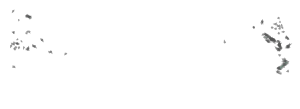

In [46]:
from shapely.ops import cascaded_union

oceania = cascaded_union([continents['Australia'], continents['Oceania']])
continents['Australia'] = oceania
continents.pop('Oceania', None)

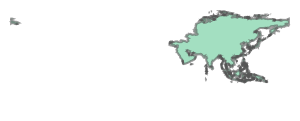

In [53]:
continents['Asia']

In [135]:
simplified_continents = {}
for continent in continents.keys():
    buffered = continents[continent].buffer(0.2)
    for other_continent in continents.keys():
        if continent == other_continent:
            continue
            
        buffered = buffered.difference(continents[other_continent])
        
    simplified_continents[continent] = buffered.intersection(countries_union)

In [136]:
[(k, v) for k, v in simplified_continents.items()]

[('Asia', <shapely.geometry.multipolygon.MultiPolygon at 0x1135ff978>),
 ('North America',
  <shapely.geometry.multipolygon.MultiPolygon at 0x11976e630>),
 ('Europe', <shapely.geometry.multipolygon.MultiPolygon at 0x11976eef0>),
 ('Africa', <shapely.geometry.multipolygon.MultiPolygon at 0x11976e6a0>),
 ('South America',
  <shapely.geometry.multipolygon.MultiPolygon at 0x11976e668>),
 ('Australia', <shapely.geometry.multipolygon.MultiPolygon at 0x11976e5c0>),
 ('Antarctica', <shapely.geometry.multipolygon.MultiPolygon at 0x11976e588>)]

In [139]:
generated_db.execute('DROP TABLE continents;')
generated_db.execute('CREATE TABLE continents (name TEXT PRIMARY KEY NOT NULL, geometry BLOB);')

In [140]:
for name in simplified_continents.keys():
    generated_db.execute('INSERT INTO continents (name, geometry) VALUES (?, ?)', [
        name, simplified_continents[name].wkb
    ])
        
generated_db.commit()

In [141]:
generated_db.execute('CREATE TABLE geohash_continents (geohash TEXT PRIMARY KEY NOT NULL, name TEXT NOT NULL);')

In [193]:
def continent_for_geohash(gh):
    pos = geohash.decode(gh)
    point = Point(pos[1], pos[0])
    
    distances = [(name, geometry.distance(point)) for name, geometry in simplified_continents.items()]
    closest_continent = min(distances, key=lambda x: x[1])[0]
    return closest_continent

max_depth = 4

def find_child_continent_geohash_mappings(previous_hash='', previous_continent=''):
    for char in geohash_characters:
        new_hash = previous_hash + char
        new_continent = continent_for_geohash(new_hash)
        
        if new_continent != previous_continent:
            generated_db.execute('INSERT INTO geohash_continents (geohash, name) VALUES (?, ?)', [ new_hash, new_continent ])
            generated_db.commit()
            
        if len(new_hash) < max_depth:
            find_child_continent_geohash_mappings(new_hash, new_continent)

find_child_continent_geohash_mappings()

ProgrammingError: Cannot operate on a closed database.

In [160]:
states_hash = pd.DataFrame(list(generated_db.execute("SELECT geohash, adm1_code FROM geohash_states_provinces"))).set_index(0)[1].to_dict()

In [169]:
import sys
sys.getsizeof(states_hash)

5242976

In [76]:
generated_db.close()